# 餐盘颜色识别

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, Markdown, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

def _IMPORT_(x):
    try:
        segs = x.split(' ')
        g = globals()
        if 'github.com' in segs[1]:
            uri = segs[1].replace('github.com', 'raw.githubusercontent.com')
            mod = uri.split('/')
            for s in ['main', 'master']:
                uri = 'https://' + '/'.join(mod[:-1]) + '/main/' + mod[-1] + '.py'
                x = requests.get(uri).text
                if x.status == 200:
                    break
        elif 'gitee.com' in segs[1]:
            mod = segs[1].split('/')
            for s in ['/raw/main/', '/raw/master/']:
                uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:]) + '.py'
                x = requests.get(uri).text
                if x.status == 200:
                    break
        elif segs[1][0] == '/':
            with open(segs[1] + '.py') as fr:
                x = fr.read()
        exec(x, g)
    except:
        pass

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 8.3.1
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed


In [2]:
###
### Common ###
###

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')
_IMPORT_('import ipywidgets as widgets')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_table(headers, data, width=900):
    ncols = len(headers)
    width = int(width / ncols)
    lralign = []
    caption = []
    for item in headers:
        astr = ''
        if item[0] == ':':
            astr = ':'
            item = item[1:]
        astr += '---'
        if item[-1] == ':':
            astr += ':'
            item = item[:-1]
        lralign.append(astr)
        caption.append(item)
    captionstr = '|'.join(caption) + chr(10)
    lralignstr = '|'.join(lralign) + chr(10)
    imgholdstr = '|'.join(['<img width=%d/>' % width] * ncols) + chr(10)
    table = captionstr + lralignstr + imgholdstr
    is_dict = isinstance(data[0], dict)
    for row in data:
        if is_dict:
            table += '|'.join([f'{row[c]}' for c in caption]) + chr(10)
        else:
            table += '|'.join([f'{col}' for col in row]) + chr(10)
    return Markdown(table)

def show_video(vidsrc, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if vidsrc.startswith('http'):
        data_url = vidsrc
    else:
        mp4 = open(vidsrc, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(imgsrc, width=None, height=None):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    if url.startswith('http'):
        response = requests.get(url)
        if response:
            imgmat = np.frombuffer(response.content, dtype=np.uint8)
            img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        else:
            return None
    else:
        img = cv2.imread(url)
        
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if size:
        if isinstance(size, int):
            size = (size, size)
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

def img2bytes(x, width=None, height=None):
    if isinstance(x, bytes):
        return x

    if isinstance(x, str):
        if os.path.isfile(x):
            x = PIL.Image.open(x).convert('RGB')
        else:
            import cairosvg
            with io.BytesIO() as fw:
                cairosvg.svg2png(bytestring=x, write_to=fw,
                        output_width=width, output_height=height)
                return fw.getvalue()

    from matplotlib.figure import Figure
    if isinstance(x, Figure):
        with io.BytesIO() as fw:
            plt.savefig(fw)
            return fw.getvalue()

    from torch import Tensor
    from torchvision import transforms
    from PIL import Image
    if isinstance(x, Tensor):
        x = transforms.ToPILImage()(x)
    elif isinstance(x, np.ndarray):
        x = Image.fromarray(x.astype('uint8')).convert('RGB')

    if isinstance(x, Image.Image):
        if width and height:
            x = x.resize((width, height))
        with io.BytesIO() as fw:
            x.save(fw, format='PNG')
            return fw.getvalue()
    raise NotImplementedError(type(x))

def img2b64(x):
    return base64.b64encode(img2bytes(x)).decode()


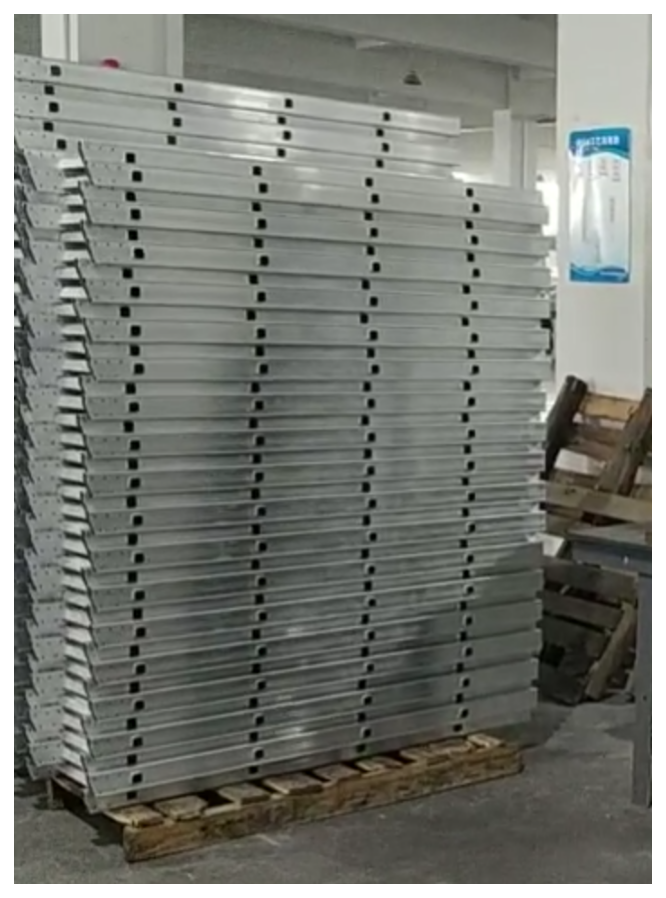

In [4]:
img_rgb = im_read('./ladder.png')
show_image(img_rgb)

In [26]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) 

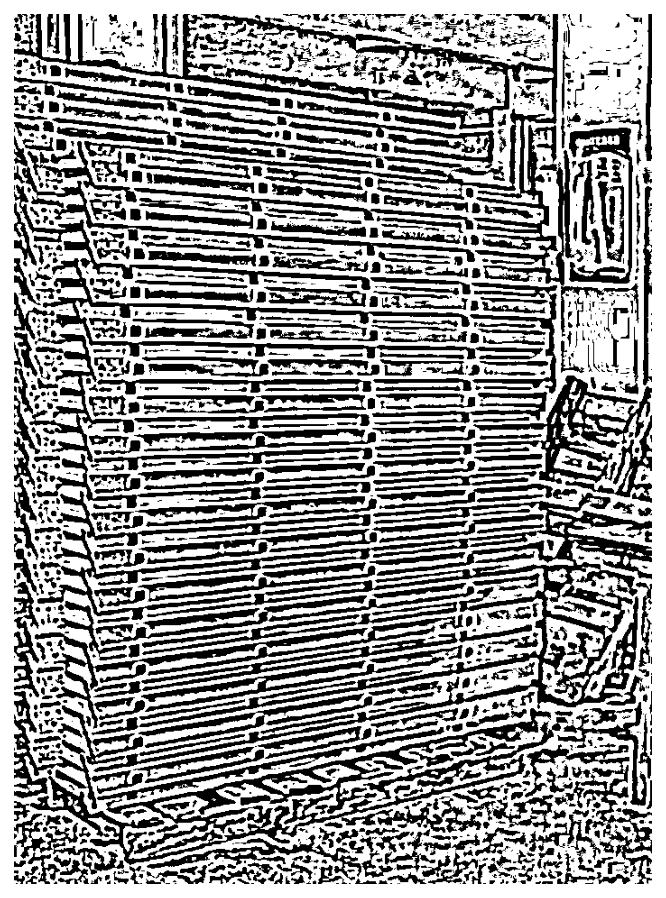

In [50]:
dst = cv2.adaptiveThreshold(img_gray, 110, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 1)
show_image(dst)

In [41]:
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3, 3))#形态学去噪
dst=cv2.morphologyEx(dst,cv2.MORPH_OPEN,element)  #开运算去噪
contours, hierarchy = cv2.findContours(dst,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)  #轮廓检测函数
cv2.drawContours(dst,contours,-1,(120,0,0),2) 

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [120, 120, 120, ...,   0,   0,   0],
       [120, 120, 120, ...,   0,   0,   0],
       [120, 120, 120, ...,   0,   0,   0]], dtype=uint8)

In [43]:
len(contours)

235

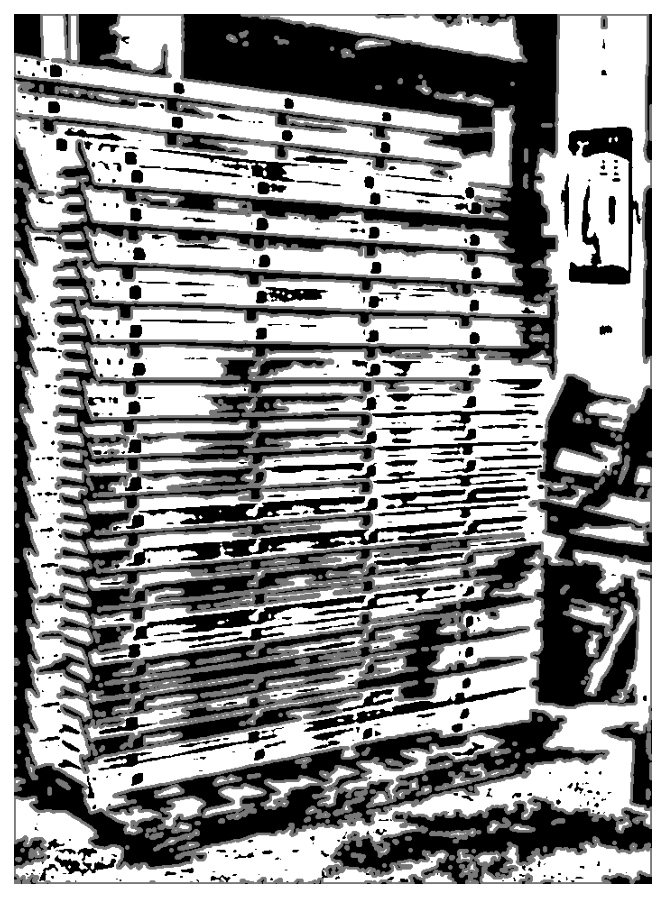

In [42]:
show_image(dst)

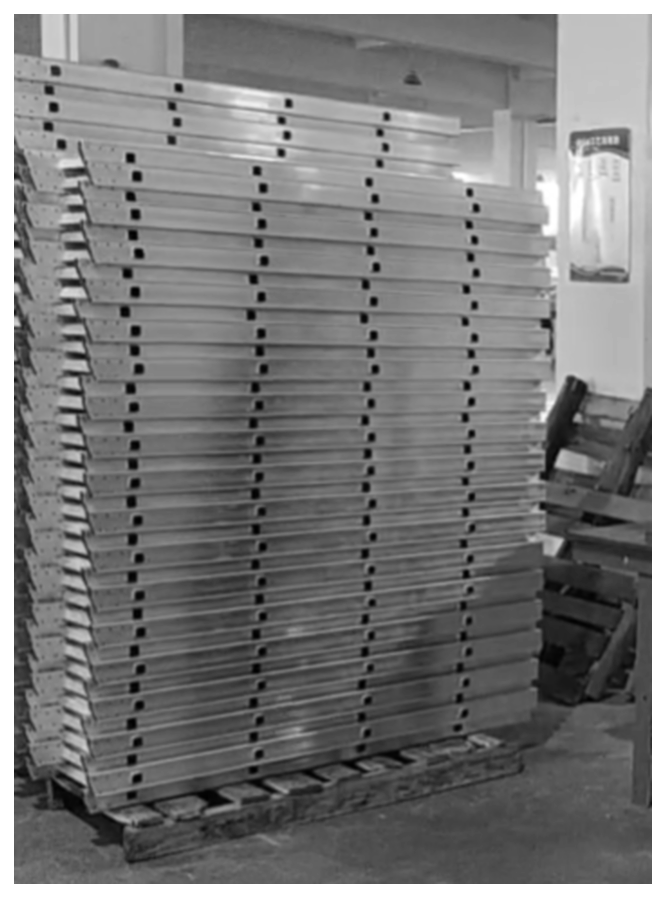

In [27]:
# img_gray = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(img_gray)
# img_blur = cv2.GaussianBlur(img_gray, (15, 15), 0)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
show_image(img_blur)

In [28]:
contours = cv2.findContours(
    img_blur,
    cv2.RETR_LIST,
    cv2.CHAIN_APPROX_SIMPLE)

In [29]:
len(contours)

2

In [13]:
cv2.drawContours(img_gray, contours, -1, (255, 255, 255), -1) # thickness: -1 for display

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

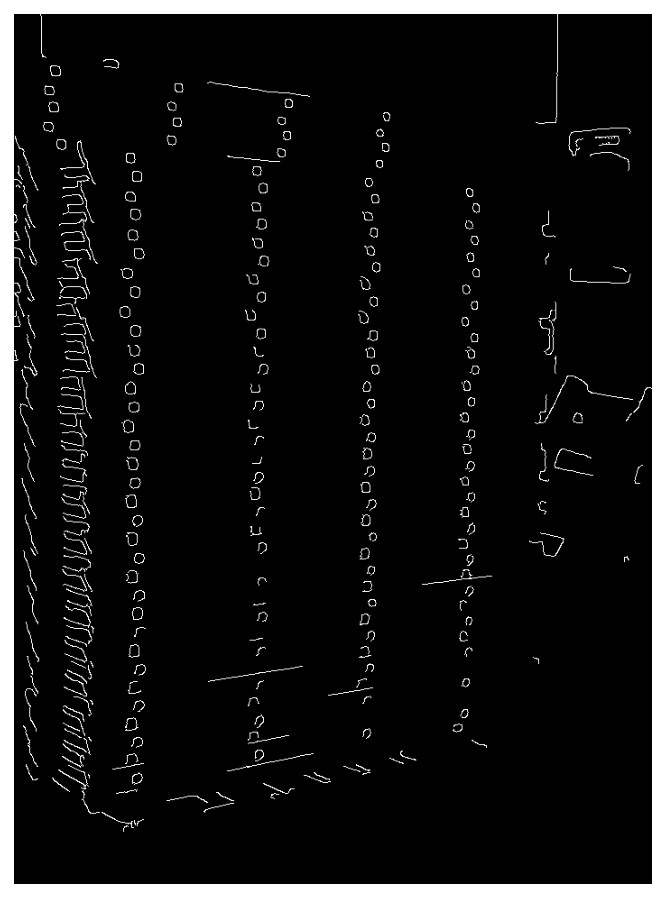

In [40]:
img_canny = cv2.Canny(img_blur, 150, 250)
show_image(img_canny)

## Recognize Dining Plate Color

In [11]:
def extract_color_features(imgpath, ellsize, iterations, thickness):
    img_rgb = im_read(imgpath)
    # add white borader for canny
    img_rgb = cv2.copyMakeBorder(
        img_rgb,
        top=2,
        bottom=2,
        left=2,
        right=2,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) 
    img_gray = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)).apply(img_gray)
    # img_blur = cv2.GaussianBlur(img_gray, (15, 15), 0)
    img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)

    img_canny = cv2.Canny(img_blur, 30, 150)

    ellipses = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (ellsize, ellsize))

    mask_close = cv2.morphologyEx(img_canny, cv2.MORPH_CLOSE, ellipses, iterations=iterations)

    contours = cv2.findContours(
        mask_close,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    contours_sorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    plate_mask = np.zeros(img_gray.shape, np.uint8)

    cv2.drawContours(plate_mask, [contours_sorted[0]], 0, (255, 255, 255), thickness)

    inner_contours = cv2.findContours(
        plate_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    inner_contours_sorted = sorted(inner_contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    edge_mask = np.zeros(img_gray.shape, np.uint8)
    cv2.drawContours(edge_mask, [inner_contours_sorted[1]], 0, (255, 255, 255), -1) # thickness: -1 for display
    rgb_masked = cv2.bitwise_and(img_rgb, img_rgb, mask=edge_mask)
    img_hsv = cv2.cvtColor(rgb_masked, cv2.COLOR_RGB2HSV)
    
    colors_count = { x:0 for x in COLORS_NAMES}
    for item in inner_contours_sorted[1]:
        x, y = item[0]
        h, s, v = img_hsv[y, x, :]
        colors_count[hsv_color(h, s, v)] += 1
        
    print(colors_count)

    # debug
    rgb_canny = cv2.cvtColor(img_canny, cv2.COLOR_GRAY2RGB)
    rgb_close = cv2.cvtColor(mask_close, cv2.COLOR_GRAY2RGB)
    rgb_plate_mask = cv2.cvtColor(plate_mask, cv2.COLOR_GRAY2RGB)
    rgb_edge_mask = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB)
    show_image(
        np.vstack([
            np.hstack([img_rgb, rgb_canny, rgb_close]),
            np.hstack([rgb_plate_mask, rgb_edge_mask, rgb_masked])
        ])
    )
# extract_color_features(test_samples[0], 15, 2, 25)

In [1]:
widgets.interact_manual(
    extract_color_features,
    imgpath=widgets.Dropdown(options=[(p.split('/')[-1][:-4], p) for p in test_samples]),
    ellsize=widgets.IntSlider(min=1, max=32, value=8),
    iterations=widgets.IntSlider(min=1, max=10, value=3),
    thickness=widgets.IntSlider(min=1, max=60, value=10),
);

NameError: name 'widgets' is not defined

## References

1. http://oa.upm.es/40591/3/TFG_JULIAN_CALDERON_GONZALEZ.pdf

2. https://realpython.com/python-opencv-color-spaces/

3. https://blog.csdn.net/eternity1118_/article/details/51492105

4. https://medium.com/analytics-vidhya/morphological-transformations-of-images-using-opencv-image-processing-part-2-f64b14af2a38

5. https://python.plainenglish.io/complete-understanding-of-morphological-transformations-in-image-processing-eadb337e9d5c

6. cv2.copyMakeBorder() https://my.oschina.net/u/4870686/blog/4956432

7. Canny原理:https://www.pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/

8. 边缘类型 https://blog.csdn.net/wsp_1138886114/article/details/82935839

9. https://medium.com/smileinnovation/capturing-your-dinner-a-deep-learning-story-bf8f8b65f26f

10. https://coderzcolumn.com/tutorials/python/interactive-widgets-in-jupyter-notebook-using-ipywidgets